In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import requests
import json
import time

df = pd.read_csv('Friskis1_team_data.csv')

#We will first set the complete DataFrames
x_keep_original = ['Gold', 'Level', 'Minions', 'Kills', 'Assists', 'Deaths', 'Towers', 'Dragons', 'Heralds', 'Gold_diff']
X_original = df[x_keep_original]
y_original = df["Win"]

def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4, figsize=(10,5), params=False):
    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)

    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns=['parameters']
        display(params)

def fit_eval(model, X_train, y_train, X_test, y_test, digits=4, figsize=(2,1), params=False):
    model.fit(X_train, y_train)

    evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits, figsize=figsize, params=params)

    return model

X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.333333, random_state=42)

#Logistic regression using the original df
log_select = fit_eval(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test)

In [41]:
import requests
import json

# Disable SSL certificate verification
requests.packages.urllib3.disable_warnings()

# Fetch the JSON data from the URL without SSL verification
url = "https://127.0.0.1:2999/liveclientdata/gamestats"
response = requests.get(url, verify=False)
data = response.json()

# Extract the gameTime value
game_time_seconds = data["gameTime"]

# Convert game_time to minutes and seconds
minutes = game_time_seconds // 60
seconds = game_time_seconds % 60

# Format minutes and seconds without decimal places
formatted_minutes = "{:.0f}".format(minutes)
formatted_seconds = "{:.0f}".format(seconds)

# Print the converted time
print("Game Time: {} minutes {} seconds".format(formatted_minutes, seconds))


# Fetch playerlist data
playerlistURL = "https://127.0.0.1:2999/liveclientdata/playerlist"
response = requests.get(playerlistURL, verify=False)
data = response.json()

# Calculate the sum of levels and save player names for players in "ORDER" team
order_levels = []
order_players = []
order_scores = {}
team1_items = []
# Calculate the sum of levels and save player names for players in "CHAOS" team
chaos_levels = []
chaos_players = []
chaos_scores = {}
team2_items = []

for obj in data:
    team = obj.get("team")
    level = int(obj["level"])
    summoner_name = obj["summonerName"]
    scores = obj["scores"]
    items = obj["items"]

    if team == "ORDER":
        order_levels.append(level)
        order_players.append(summoner_name)
        for key in scores:
            order_scores[key] = order_scores.get(key, 0) + scores[key]
        team1_items.extend(item["itemID"] for item in items)
    elif team == "CHAOS":
        chaos_levels.append(level)
        chaos_players.append(summoner_name)
        for key in scores:
            chaos_scores[key] = chaos_scores.get(key, 0) + scores[key]
        team2_items.extend(item["itemID"] for item in items)

# Calculate the average levels for each team
order_average = sum(order_levels) / len(order_levels)
chaos_average = sum(chaos_levels) / len(chaos_levels)

# Print the averages
print(f"Average of levels for players in the 'ORDER' team: {order_average}")
print(f"Players in the 'ORDER' team: {', '.join(order_players)}")
print(f"Average of levels for players in the 'CHAOS' team: {chaos_average}")
print(f"Players in the 'CHAOS' team: {', '.join(chaos_players)}")

# Print the sums of scores
print("Sum of scores for players in 'ORDER' team:")
print(order_scores)
print("Sum of scores for players in 'CHAOS' team:")
print(chaos_scores)


def collect_items_by_team(json_data):
    team1_items = []
    team2_items = []

    for player in json_data:
        team = player["team"]
        items = player["items"]

        if team == "ORDER":
            team1_items.extend(item["itemID"] for item in items)
        elif team == "CHAOS":
            team2_items.extend(item["itemID"] for item in items)

    return team1_items, team2_items

# Fetch playerlist data
url = "https://127.0.0.1:2999/liveclientdata/playerlist"
response = requests.get(url, verify=False)

# Check if the request was successful
if response.status_code == 200:
    json_data = response.json()
    team1_items, team2_items = collect_items_by_team(json_data)
    print("Team 1 Items:")
    print(team1_items)
    print("Team 2 Items:")
    print(team2_items)
else:
    print("Failed to fetch JSON data. Status code:", response.status_code)


# Static URL for the items.json data
json_url = "https://cdn.merakianalytics.com/riot/lol/resources/latest/en-US/items.json"

def get_item_price(item_id):
    try:
        response = requests.get(json_url)
        data = response.json()

        item_data = data[str(item_id)]
        total_price = item_data["shop"]["prices"]["total"]
        return total_price

    except (requests.RequestException, json.JSONDecodeError, KeyError):
        return None

def calculate_total_item_price(item_ids):
    total_price = 0
    for item_id in item_ids:
        price = get_item_price(item_id)
        if price is not None:
            total_price += price
    return total_price

# Calculate total item price for team 1
team1_total_price = calculate_total_item_price(team1_items)

# Calculate total item price for team 2
team2_total_price = calculate_total_item_price(team2_items)

# Print the results
print(f"Total item price for team 1: {team1_total_price} gold.")
print(f"Total item price for team 2: {team2_total_price} gold.")

url = "https://127.0.0.1:2999/liveclientdata/eventdata"

# Make the HTTP GET request
response = requests.get(url, verify=False)  # Set verify to False if using self-signed certificate

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()

    # Initialize counters
    team_order_dragon_kills = 0
    team_order_herald_kills = 0
    team_chaos_dragon_kills = 0
    team_chaos_herald_kills = 0

    # Iterate over the events
    for event in data["Events"]:
        event_name = event.get("EventName", "")

        if event_name == "DragonKill":
            killer_name = event.get("KillerName", "")

            if killer_name in order_players:
                team_order_dragon_kills += 1
            else:
                team_chaos_dragon_kills += 1
                

        elif event_name == "HeraldKill":
            killer_name = event.get("KillerName", "")

            if killer_name in order_players:
                team_order_herald_kills += 1
            else:
                team_chaos_herald_kills += 1

    # Print the results
    print("Team Order:")
    print("Dragon kills:", team_order_dragon_kills)
    print("Herald kills:", team_order_herald_kills)
    print()
    print("Team Chaos:")
    print("Dragon kills:", team_chaos_dragon_kills)
    print("Herald kills:", team_chaos_herald_kills)
else:
    # If the request was not successful, print the error message
    print("Error:", response.status_code, response.reason)


order_turrets = ['Turret_T1_L_03_A', 'Turret_T1_L_02_A', 'Turret_T1_C_06_A', 'Turret_T1_C_01_A',  'Turret_T1_C_05_A',  'Turret_T1_C_04_A', 'Turret_T1_C_03_A', 'Turret_T1_R_03_A', 'Turret_T1_R_03_A', 'Turret_T1_R_02_A', 'Turret_T1_C_07_A', 'Turret_T1_C_02_A']

url = "https://127.0.0.1:2999/liveclientdata/eventdata"

# Make the HTTP GET request
response = requests.get(url, verify=False)  # Set verify to False if using self-signed certificate

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()

    # Initialize counters
    team_order_turrets = 0
    team_chaos_turrets = 0

    # Iterate over the events
    for event in data["Events"]:
        event_name = event.get("EventName", "")

        if event_name == "TurretKilled":
            turret_killed_name = event.get("TurretKilled", "")

            if turret_killed_name in order_turrets:
                team_chaos_turrets += 1
            else:
                team_order_turrets += 1
                
    # Print the results
    print("Team Order:")
    print("Turret kills:", team_order_turrets)
    print()
    print("Team Chaos:")
    print("Turret kills:", team_chaos_turrets)
else:
    # If the request was not successful, print the error message
    print("Error:", response.status_code, response.reason)

team_1 = {
    "Gold": team1_total_price,
    "Level": order_average,
    "Minions": order_scores["creepScore"],
    "Kills": order_scores["kills"],
    "Assists": order_scores["assists"],
    "Deaths": order_scores["deaths"],
    "Towers": team_order_turrets,
    "Dragons": team_order_dragon_kills,
    "Heralds": team_order_herald_kills,
    "Gold_diff": team1_total_price - team2_total_price
}

team_2 = {
    "Gold": team2_total_price,
    "Level": chaos_average,
    "Minions": chaos_scores["creepScore"],
    "Kills": chaos_scores["kills"],
    "Assists": chaos_scores["assists"],
    "Deaths": chaos_scores["deaths"],
    "Towers": team_chaos_turrets,
    "Dragons": team_chaos_dragon_kills,
    "Heralds": team_chaos_herald_kills,
    "Gold_diff": team2_total_price - team1_total_price
}


Game Time: 14 minutes 45.76043701171875 seconds
Average of levels for players in the 'ORDER' team: 9.6
Players in the 'ORDER' team: Zueb, ZXΥ, człowiek z gazu, canerxd1, Opie
Average of levels for players in the 'CHAOS' team: 9.2
Players in the 'CHAOS' team: ll111ll111ll, MikotoSenpai, WP SIUUUUUUUUUUU, Raise the puppy, Sunfry
Sum of scores for players in 'ORDER' team:
{'assists': 13, 'creepScore': 400, 'deaths': 16, 'kills': 13, 'wardScore': 47.09006690979004}
Sum of scores for players in 'CHAOS' team:
{'assists': 16, 'creepScore': 430, 'deaths': 13, 'kills': 16, 'wardScore': 53.21568179130554}
Team 1 Items:
[1055, 3071, 3047, 1036, 3340, 2422, 3142, 1102, 3057, 1036, 3364, 1054, 1082, 6657, 3020, 1058, 3364, 1083, 6672, 1001, 1038, 3340, 3851, 3070, 1004, 6617, 3158, 3364]
Team 2 Items:
[3047, 1083, 3153, 1055, 3340, 6632, 2031, 1103, 2055, 3047, 3364, 2031, 1056, 1001, 6655, 3363, 2031, 3087, 3006, 1036, 1018, 3134, 3340, 3802, 3859, 3009, 2055, 3364]
Total item price for team 1: 24

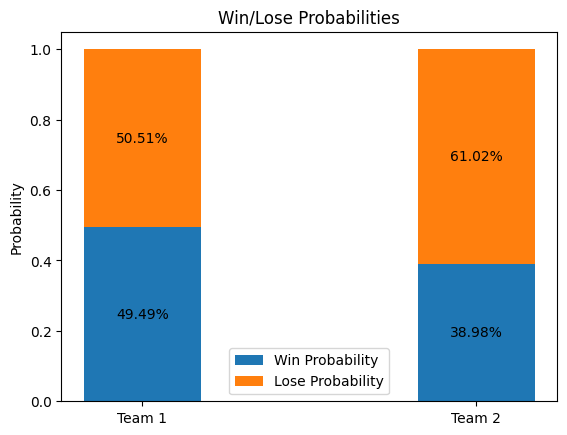

In [42]:
# Create DataFrame and select features for team 1
team_1_df = pd.DataFrame(team_1, index=[0])
team_1_features = team_1_df[x_keep_original]

# Make prediction for team 1
team1_prediction = log_select.predict(team_1_features)
team1_prediction_probabilities = log_select.predict_proba(team_1_features)
team1_win_probability = team1_prediction_probabilities[0][1]

# Create DataFrame and select features for team 2
team_2_df = pd.DataFrame(team_2, index=[0])
team_2_features = team_2_df[x_keep_original]

# Make prediction for team 2
team2_prediction = log_select.predict(team_2_features)
team2_prediction_probabilities = log_select.predict_proba(team_2_features)
team2_win_probability = team2_prediction_probabilities[0][1]

# Calculate lose probabilities
team1_lose_probability = 1 - team1_win_probability
team2_lose_probability = 1 - team2_win_probability

# Define labels and data
labels = ["Team 1", "Team 2"]
win_probabilities = [team1_win_probability, team2_win_probability]
lose_probabilities = [team1_lose_probability, team2_lose_probability]

# Create the bar chart
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x, win_probabilities, width, label="Win Probability")
ax.bar(x, lose_probabilities, width, bottom=win_probabilities, label="Lose Probability")

# Customize the plot
ax.set_ylabel("Probability")
ax.set_title("Win/Lose Probabilities")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add annotations to the plot
for i in range(len(labels)):
    ax.annotate("{:.2%}".format(win_probabilities[i]), xy=(x[i], win_probabilities[i]/2), ha='center', va='center')
    ax.annotate("{:.2%}".format(lose_probabilities[i]), xy=(x[i], win_probabilities[i]+lose_probabilities[i]/2), ha='center', va='center')

# Display the plot
plt.show()